# PSF Photometry using effective PSF models (in python!)

We present a software stack for fitting the PSF models developed by J Anderson for HST/WFC3 to perform high precision PSF photometry.  In general, the process is as follows:
1. Find and fit stars in each image using the PSF model
2. Align the images using the PSF fitted catalogs
3. Match the stars and collate/average the measurements into one final catalog.
In this notebook, we show a simple workflow for performing these tasks using the psf_tools package.



### Versions!

NOTE: These tools require an installation of astroconda, using python 3.6, and photutils >= 0.7.1.  It also requires astroquery and skimage >=0.15.0

# Table of Contents
0. [Data Download](#dl)

1a. [Fortran Interface](#fortran)

1b. [Python Interface](#python)


2. [Align Images](#align)


3. [Collate/Average Measurements](#average)


4. [Results](#results)

In [1]:
# some parameters we will use consistently
hmin = 5
fmin = 1000.
pmax= 66000.

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations

from psf_tools import run_hst1pass, run_python_psf_fitting, align_images, make_final_table, \
                    match_final_catalogs, match_to_master_catalog



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 10
plt.rcParams.update({'axes.titlesize' : '18',
                     'axes.labelsize' : '14',
                     'xtick.labelsize' : '14',
                     'ytick.labelsize' : '14'})
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
%matplotlib inline

# 0. First, download some data
<a id="dl">

Let's download some data from the outer regions of Omega Cen to start.  We will use images in 2 filters, 2 epochs each.

In [4]:
cd oc/

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/oc


In [6]:
obsTable = Observations.query_criteria(project='HST',proposal_id='14118', obs_id='ICTJ4[5678]*', obstype='all')
products = Observations.get_product_list(obsTable)
filtered_products = Observations.filter_products(products,mrp_only=False, productSubGroupDescription='FLC')
dl_tbl = Observations.download_products(filtered_products,mrp_only=False)
files = []
for f in dl_tbl['Local Path']:
    filename = os.path.split(f)[-1]
    files.append(filename)
    if not os.path.exists(filename):
        shutil.move(f, '.')


NameError: name 'dl_tbl' is not defined

### Multiple filters in downloaded data, only look at/fit one band at a time

In [5]:
files = glob.glob('ictj*flc.fits')

In [6]:
input_images =[im for im in  sorted(files) if fits.getval(im, 'FILTER')== 'F814W']

In [7]:
input_images

['ictj45ahq_flc.fits',
 'ictj45ajq_flc.fits',
 'ictj45b9q_flc.fits',
 'ictj46csq_flc.fits',
 'ictj46cuq_flc.fits',
 'ictj46czq_flc.fits']

### Lets fit just the longer exposures in this example

In [8]:
input_images = [im for im in input_images if fits.getval(im, 'EXPTIME') > 200.]

In [19]:
for im in input_images:
    print(im, fits.getval(im, 'exptime'), fits.getval(im, 'date-obs'), fits.getval(im, 'filter'))

ictj45ajq_flc.fits 1253.0 2016-06-27 F814W
ictj45b9q_flc.fits 1345.0 2016-06-27 F814W
ictj46cuq_flc.fits 1253.0 2016-07-04 F814W
ictj46czq_flc.fits 1345.0 2016-07-04 F814W


# 1a. Fortran Interface<a id="fortran"></a>

### See input options:

In [57]:
run_hst1pass?

In general, the default parameters passed are suitable for most use cases.  The only parameters that would be recommeneded to edit would be `fmin`, `pmax`, and `hmin`.  There are also extra keyword arguments that can be passed to the call, but support for those parameters is not guaranteed.

To see other keyword arguments, run the fortran executable with no arguments

In [10]:
import psf_tools
print(psf_tools.PSFPhot._get_exec_path())

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/psf_tools/hst1pass_darwin.e


Replace the path below with whatever was output above

In [11]:
! /Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/psf_tools/hst1pass_darwin.e

                                           
 This routine takes sevaral args (3 req)   
                                           
 hst2xym HMIN=5                            
         FMIN=1000                         
         [PSF=AUTO/FILE/APPHOT]            
         [GDC=AUTO/FILE/NONE]  (distortn)  
         [PMAX=99999]                      
         [QMAX= 0.1]                       
         [CMIN=-1.0]                       
         [CMIN= 0.1]                       
         [SHOW_USE=NO/AUTO/X] image search 
         [SHOW_FND=NO/AUTO/X] find report  
         [SHOW_REF=NO/AUTO/X] ref-frame img
         [SHOW_SUB=NO/AUTO/X] subt image   
         [SHOW_MSK=NO/AUTO/X] mask         
         [SHOW_ALL=NO/AUTO/X] show all     
         [PERTn=YES/AUTO/FILE]             
         [FOCUS=-1(find),0(mid),rF]        
         [REF-FRAME PARAMETERS]            
         [IMIN=500] [IMAX=510]             
         [JMIN=922] [JMAX=932]             
         [MSORT+] [HSORT+]      

### Run the PSF photometry

The executable is ran in the following cell using the Fortran engine.  Supplying `focus=-1` parameter tells the software to determine and use the focus dependent PSF library.  If not supplied then the standard (spatially dependent, but non focus dependent PSFs are used.

In [ ]:
catalogs = run_hst1pass(input_images=input_images, hmin=hmin, fmin=fmin, pmax=pmax)

### See the output catalogs

In [12]:
# If you already have the output catalogs, and dont want to rerun hst1pass
catalogs = [im.replace('.fits', '.xympqks') for im in input_images]

In [13]:
catalogs

['ictj45ajq_flc.xympqks',
 'ictj45b9q_flc.xympqks',
 'ictj46cuq_flc.xympqks',
 'ictj46czq_flc.xympqks']

'If ran with the flag `focus = -1` (uses focus dependent PSF) focus of image can be output

In [14]:
from psf_tools.PSFPhot import check_focus

In [15]:
check_focus(catalogs)

{'ictj45ajq_flc.xympqks': 0.0,
 'ictj45b9q_flc.xympqks': 0.0,
 'ictj46cuq_flc.xympqks': 0.0,
 'ictj46czq_flc.xympqks': 0.0}

In [16]:
output_catalogs = []
for im in input_images:
    cat_str = im.replace('.fits', '_sci?_xyrd.cat')
    output_catalogs += glob.glob(cat_str)
output_catalogs = sorted(output_catalogs)

##### The hst1pass files are broken up per chip.  The following catalogs should be used for the exposure level analysis

In [58]:
Table.read('ictj45ajq_flc_sci1_xyrd.cat', format='ascii.commented_header')

x,y,r,d,m,p,q,s
float64,float64,float64,float64,float64,float64,float64,float64
126.9404,6.0902,201.56954330835657,-47.620491037904415,-13.225,31420.77,0.027,68.89
1698.5946,6.2038,201.55367830165133,-47.63413354575402,-9.617,1423.42,0.856,39.48
1709.4504,5.817,201.55357347031153,-47.6342306376407,-9.511,1269.11,0.743,42.34
1840.799,5.8899,201.55224010818216,-47.635375881772454,-12.019,10582.78,0.04,47.55
3450.8806,6.4184,201.53581450610454,-47.64948611759321,-12.004,9103.64,0.08,58.42
1143.6995,7.1868,201.55928201649414,-47.62929643457578,-8.498,635.23,0.574,33.97
1430.6652,7.3608,201.5563770353035,-47.63179182727162,-12.201,10663.25,0.027,40.49
3020.1968,7.0908,201.5402129281604,-47.645693381296,-11.022,5643.26,0.737,29.88
3849.1968,6.5878,201.53172526322155,-47.652997173605534,-8.766,521.76,0.65,31.51


In [17]:
output_catalogs

['ictj45ajq_flc_sci1_xyrd.cat',
 'ictj45ajq_flc_sci2_xyrd.cat',
 'ictj45b9q_flc_sci1_xyrd.cat',
 'ictj45b9q_flc_sci2_xyrd.cat',
 'ictj46cuq_flc_sci1_xyrd.cat',
 'ictj46cuq_flc_sci2_xyrd.cat',
 'ictj46czq_flc_sci1_xyrd.cat',
 'ictj46czq_flc_sci2_xyrd.cat']

# Python interface<a id="python"></a>

A fully python based interface is  available for the PSF fitting.  The python interface has a pared down feature set, and does not yet support the focus based PSFs (coming soon!), and runs slower, but has a more familiar usage compared to the Fortran interface.   The fortran interface can also much more reliably measure UVIS saturated stars, whereas the Python interface cannot. The output `xyrd` catalogs are the same as the fortran, and so either interface can be selected for use for the initial fittings, and then the following alignment/collating steps are the same.

### Look at inputs

In [59]:
run_python_psf_fitting?

In general, the parameters to the python interface are very similar.  More of the keyword arguments are specified directly (qmax, cmin, cmax), and have docstrings specifying their use.  You can also specify the number of CPUs to distribute the fitting across, which subtrantially improves performance when > 1 (default is to use all CPUs).  

### Run the python fitting

In [ ]:
run_python_psf_fitting(input_images, hmin=hmin, fmin=fmin, pmax=pmax)

### Look at one of the xyrd catalogs

The xyrd catalogs contain the outputs from the fitting.  Depending on what was selected in the fitting parameters, the number of columns may vary.  However, the important columns are:

`x`, `y`: The pixel positions of the source measured (1-indexed)

`r`, `d`: The decimal degree RA and Dec of the source measured

`m`: The instrumental magnitude of the fitted PSF (`-2.5 * np.log10(flux [electrons])`)

`q`: The fit quality (see docstring of `run_python_psf_fitting()` for more info)

In [19]:
Table.read(output_catalogs[0], format='ascii.commented_header')

x,y,r,d,m,p,q,s
float64,float64,float64,float64,float64,float64,float64,float64
3456.623,5.508,201.53576780409784,-47.64954250492913,-12.257,10252.03,0.036,60.13
4090.566,4.816,201.52926798659138,-47.65514064330758,-12.915,20793.87,0.085,47.6
126.94,6.09,201.56954309201672,-47.62049103260623,-13.225,31420.77,0.027,68.89
1840.799,5.89,201.5522398747949,-47.635375872342685,-12.019,10582.78,0.04,47.55
3450.881,6.418,201.53581426693097,-47.64948610945756,-12.004,9103.64,0.08,58.42
1430.665,7.361,201.55637680473959,-47.63179181683829,-12.201,10663.25,0.027,40.49
2910.116,7.614,201.54133026715866,-47.644723427944704,-12.912,23246.69,0.037,49.73
3087.673,7.691,201.53951483436,-47.646282370166034,-11.25,4679.92,0.037,37.69
3112.823,8.754,201.5392431643135,-47.64649661835765,-8.235,338.05,0.109,33.94


# 2. Align the images <a id="align"></a>

With the image based catalogs, we can now align them using the accurate positions from the PSF fitting steps.  The alignment not only removes pointing error between images, but also makes the images/catalogs useful for astrometric studies.  This step also corrects the RAs/Decs in the catalogs with the updated values resulting from the alignment.  Furthermore, aligning the images is crucial for tbe final matching/averaging step.

### See options for aligning the images using the catalogs from previous step

In [31]:
align_images?

Setting `gaia=True` will automatically download and align the catalogs to Gaia DR2 (no proper motions added due to low precision of Gaia proper motions).  This yields high accuracy absolute astrometric measurements!

Calculating coordinate ranges for Gaia query:
INFO: Query finished. [astroquery.utils.tap.core]
Sources returned: 3243
Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 12:52:50.905 (21/02/2022) 

Version Information
--------------------
Python Version [GCC Clang 10.0.0 ]
3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
numpy Version -> 1.19.1 
astropy Version -> 4.0.2 
stwcs Version -> 1.6.1 

Finding shifts for: 
    ictj45ajq_flc.fits
    ictj45b9q_flc.fits
    ictj46cuq_flc.fits
    ictj46czq_flc.fits

===  Source finding for image 'ictj45ajq_flc.fits':
     Found 8459 objects.
     Found 8570 objects.
===  FINAL number of objects in image 'ictj45ajq_flc.fits': 17029

===  Source finding for image 'ictj45b9q_flc.fits':
     Found 8503 objects.
     Found 8790 objects.
===  FINAL number of objects in image 'ictj45b9q_flc.fits': 17293

===  Source finding for image 'ictj46cuq_flc.fits':
     Found 7866 objects.
     Found 8111 objects.
=== 

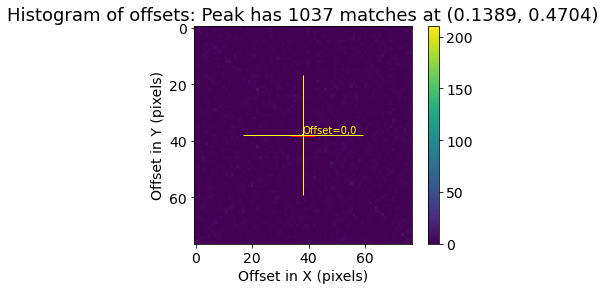

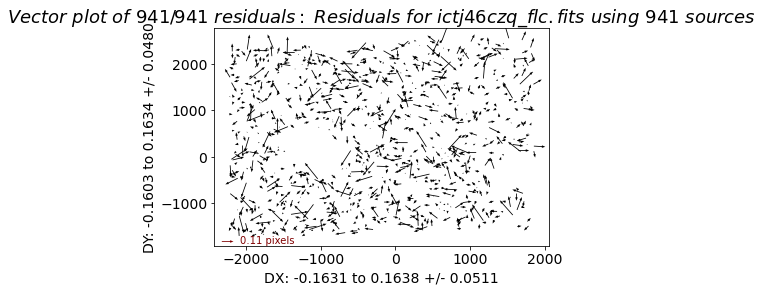

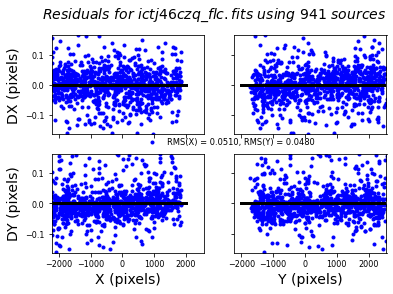

In [20]:
align_images(input_images, searchrad=1.5, gaia=True, wcsname='DEMO', prop=True)


### Can also run with any arguments passed to TweakReg


Calculating coordinate ranges for Gaia query:
Query finished.
Sources returned: 3243
Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 10:53:53.08 (27/01/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.17.4 
astropy Version -> 3.2.3 
stwcs Version -> 1.5.3 

Finding shifts for: 
    ictj45ajq_flc.fits
    ictj45b9q_flc.fits
    ictj46cuq_flc.fits
    ictj46czq_flc.fits

===  Source finding for image 'ictj45ajq_flc.fits':
     Found 4406 objects.

     Applying flux limits...
         minflux = -11.0
         maxflux = -14.0
         fluxunits = 'mag'
         nbright = None
     Removed 2970 sources based on flux limits.
     Found 4349 objects.

     Applying flux limits...
         minflux = -11.0
         maxflux = -14.0
         fluxunits = 'mag'
         nbright = None
     Removed 2956 sources ba


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 2.4e-07 (deg)

Final solution based on  517  objects.
wrote XY data to:  ictj46czq_flc_catalog_fit.match
Total # points: 517
# of points after clipping: 517
Total # points: 517
# of points after clipping: 517

....Updating header for ictj46czq_flc.fits...


Processing ictj46czq_flc.fits['SCI',1]

Updating header for ictj46czq_flc.fits[1]
WCS Keywords

CD_11  CD_12: -6.8546617622974295e-06 -9.102200083923202e-06
CD_21  CD_22: -8.68870210192187e-06 6.2922314973972295e-06
CRVAL    : 201.52842046625955 -47.62738681360896
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plate Scale : 0.03984143785800866
ORIENTAT : -55.34440340752242
WCSNAME  :  TWEAK

Processing ictj46czq_flc.fits['SCI',2]

Updating header for ictj46czq_flc.fits[4]
WCS Keywords

CD_11  CD_12: -6.875300758852858e-06 -8.98489818014275e-06
CD_21  CD_22: -8.594250867866625e-06 6.231386072486531e-06
CRVAL    : 201.50049476744212 -47.614341918078125
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plat

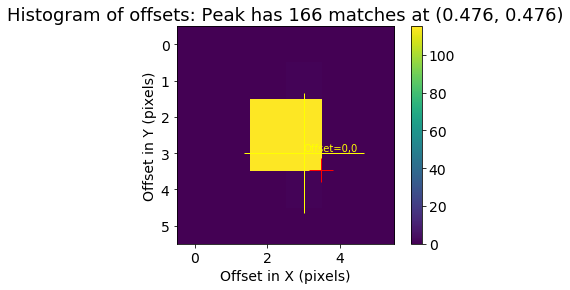

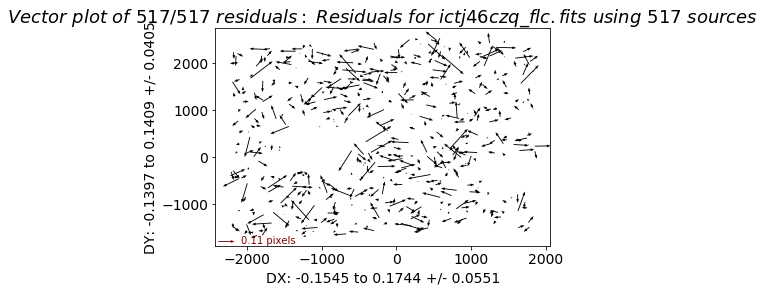

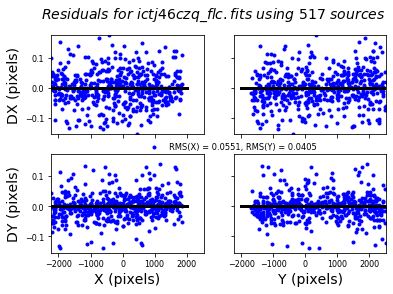

In [30]:
align_images(input_images, searchrad=.1, gaia=True, fluxcol=5, maxflux=-14., minflux=-11., fluxunits='mag')

#### Can look at shift file, saved as shifts.txt

The columns here are `xshift`, `yshift` (pixels), `rotation` (deg), `scale`, `xrms`, and `yrms`(pixels)

In [32]:
cat shifts.txt

# frame: output
# refimage: shifts_wcs.fits[wcs]
# form: delta
# units: pixels
ictj45ajq_flc.fits    0.001610  0.000232    359.999944     1.000002   0.051366  0.036729
ictj45b9q_flc.fits    -0.000896  0.006751    0.000079     1.000006   0.056577  0.038113
ictj46cuq_flc.fits    0.001214  0.002585    0.000135     1.000004   0.052337  0.033215
ictj46czq_flc.fits    0.005670  -0.000149    359.999986     1.000000   0.055086  0.040456


Aligning to gaia may result in slightly higher RMS values than aligning relatively (`gaia=False` and  `reference_catalog=None`) due to proper motions/inaccuracies in the gaia catalog.

In [ ]:
align_images(input_images, searchrad=.1, fluxcol=5, maxflux=-14., minflux=-11., fluxunits='mag')

In [ ]:
cat shifts.txt

# 3 Match/Average the catalogs into final catalog<a id="average"></a>

The final step takes the astrometrically corrected images/catalogs, and matches common stars between them, averaging those measurements into one final catalog as well as providing errors on each of those measurements, while clipping erroneous values.  It also flux calibrates (applies aperture, pixel area map, and zerpoint correction) the magnitudes, to make them ready for science!  This software also has the ability to produce a simple drizzled image of the input images, as to have a corresponding data file

### See options for final collation of the table

In [97]:
make_final_table?

In [21]:
tbl_i = make_final_table(input_images, min_detections=3)

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/photometry_tools/background_median.py:96: RuntimeWarning: invalid value encountered in true_divide
  values = cutout * mask.data / mask.data
/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/photometry_tools/photometry_with_errors.py:126: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


0.2572684630241868
Computed aperture correction of -0.001012557269455705           using 600 stars for ictj45ajq_flc_sci1_xyrd.cat
0.24281110690199448
Computed aperture correction of -0.0053560011015036935           using 785 stars for ictj45ajq_flc_sci2_xyrd.cat
0.3093547404520409
Computed aperture correction of -0.024393797559156383           using 764 stars for ictj45b9q_flc_sci1_xyrd.cat
0.36436641736944964
Computed aperture correction of -0.018724195203203564           using 845 stars for ictj45b9q_flc_sci2_xyrd.cat
0.1805726786337658
Computed aperture correction of -0.06271634151378969           using 877 stars for ictj46cuq_flc_sci1_xyrd.cat


/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/photometry_tools/photometry_with_errors.py:147: RuntimeWarning: invalid value encountered in sqrt
  flux_error = variance ** .5


0.20698113730015244
Computed aperture correction of -0.04415223243378463           using 920 stars for ictj46cuq_flc_sci2_xyrd.cat
0.22817953585507134
Computed aperture correction of -0.057986524930830896           using 924 stars for ictj46czq_flc_sci1_xyrd.cat
0.2298925225850592
Computed aperture correction of -0.03920951178907561           using 982 stars for ictj46czq_flc_sci2_xyrd.cat


/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/psf_tools/PSFPhot.py:348: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_int_coords = np.array(all_int_coords)


Computing image coverage map.

Matching stars from input images with peaks in peakmap
N matched: 3118
N matched: 3493
N matched: 2515
N matched: 3618
N matched: 3619
N matched: 3124
N matched: 3734
N matched: 2550

Final step: collating properties of matched stars
Pixel Area Map correction complete
(8, 7227)
Median aperture_correction -0.031801654674116
Clipping the fit quality
Rejected 0 measurements
Performing zeropoint normalization


In [22]:
tbl_i

mbar,rbar,dbar,qbar,xbar,ybar,mstd,rstd,dstd,qstd,xstd,ystd,n,n_expected
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
26.347543184566266,201.5532678009065,-47.6170207176422,0.25933333333333336,437.56982310028815,1314.667251903655,0.008501489307289124,1.0225688749985999e-06,3.1810580352771535e-07,0.053989710953929806,0.05882611087763842,0.0360230988022281,3,3
24.11319279063767,201.5514977126787,-47.616189622567155,0.09033333333333333,437.59971310336476,1446.7923326671182,0.02377033778455126,1.7780754449047116e-07,2.911253757414861e-07,0.031626290048347785,0.02692865503928673,0.00965379009543568,3,3
23.738527340027762,201.55722032195877,-47.618941590742374,0.11599999999999999,442.3691562838538,1016.2629734282846,0.06494784050838417,4.949824427949376e-07,1.5601071642640672e-07,0.09807140255956372,0.016113438727576767,0.029332235422761192,3,3
21.759443863507062,201.55189875688822,-47.616477743216315,0.028333333333333335,445.03403002993304,1411.6712343157033,0.005189047274473589,2.0668988785879304e-07,1.7548814900805002e-07,0.00498887651569859,0.010737533568697487,0.017298294295400033,3,3
23.156845718362394,201.54509728385037,-47.61329649216432,0.074,446.0907667209924,1918.73301495812,0.043333804395847164,7.46435408582216e-07,2.2185322946373654e-07,0.03965686153324122,0.02663227114511654,0.04227971513619299,3,3
22.51191309663099,201.5445408058221,-47.61304671752591,0.065,446.9630278458785,1959.6744492899022,0.059026786046914755,7.178352910607167e-08,5.406547289152548e-07,0.04270831300812525,0.03858242731916083,0.030725509095255055,3,3
24.155028247483433,201.5401211468774,-47.61096738370809,0.081,446.78039370083206,2289.8101287678924,0.024370718998073807,3.4779780032291066e-07,3.849540992619521e-07,0.009416297927883692,0.023897533157385915,0.03326073587188684,3,3
23.31612065121682,201.55449383300422,-47.61774033560829,0.04533333333333334,448.2842337042623,1215.6742465729906,0.00702897263814857,1.4934288361583942e-07,2.0068165978168428e-07,0.01391242450313947,0.012456238385772799,0.01615580783700523,3,3
22.873439480087587,201.53906602621146,-47.61050280159811,0.09166666666666667,449.1126458979811,2366.972202364238,0.031671412042209475,4.881992708841484e-08,1.3441827179541874e-07,0.04793282336307298,0.010349258738754268,0.007142141346144851,3,3


# 4. See the results!<a id="results"></a>
The columns are mbar, rbar, dbar, qbar, xbar, and ybar which are mean magnitude (instrumental), RA, Dec, Q (fit quality), X position in the output frame, and Y position in the output frame.  The columns ending in 'std' are the standard deviations of the values.  The column 'n' is the number of times that source was detected (and not clipped out from the averaging).  The column `n_expected` is the number of images that covered that sky position, and thus the total number of times that star could have been detected by the input images.

### To access a column from the table, the syntax is `tbl[<colname>]` as seen below

In [24]:
tbl_i = Table.read('F814W_final_cat.txt', format='ascii.commented_header')

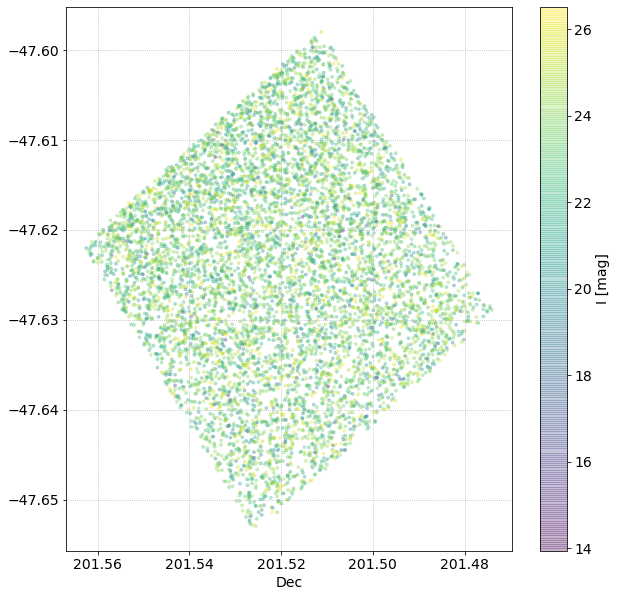

In [44]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['rbar'], tbl_i['dbar'], c=tbl_i['mbar'], s = 8, alpha=.3)
plt.xlim(plt.xlim()[::-1]) # reverse x axis for RA
plt.xlabel('RA')
plt.xlabel('Dec')
cb = plt.colorbar()
cb.set_label('I [mag]')
plt.grid(ls=':')

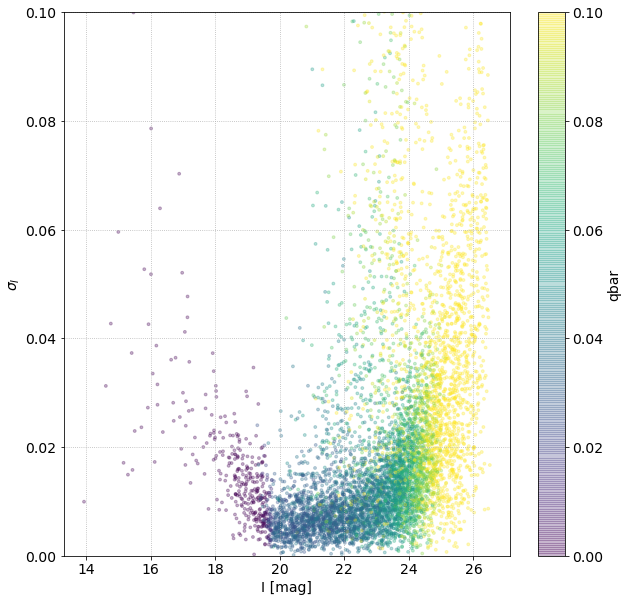

In [45]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['mbar'], tbl_i['mstd'], c=tbl_i['qbar'], s = 8, alpha=.3, vmin=0., vmax=.1, cmap='viridis')
plt.ylim(-.0,.1)
plt.xlabel('I [mag]')
plt.ylabel('$\sigma_I$')
cb = plt.colorbar()
cb.set_label('qbar')
plt.grid(ls=':')

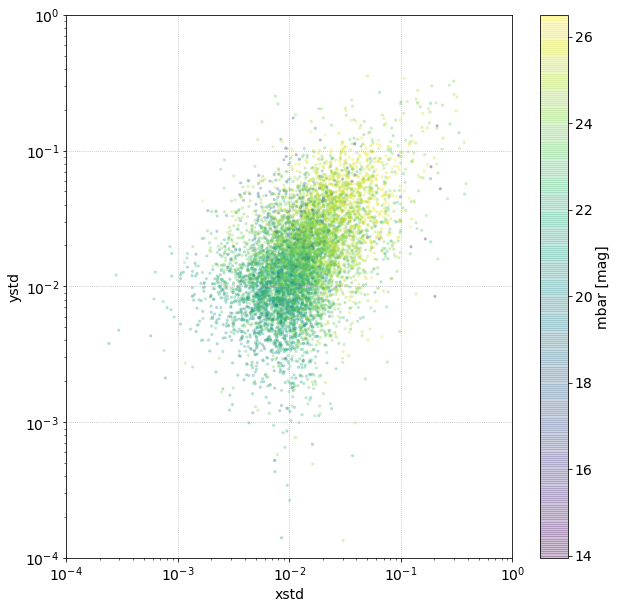

In [46]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['xstd'], tbl_i['ystd'], s = 5, alpha=.25, c=tbl_i['mbar'], cmap='viridis')
plt.xlim(0.0001, 1)
plt.ylim(0.0001, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('xstd')
plt.ylabel('ystd')
cb = plt.colorbar()
cb.set_label('mbar [mag]')
plt.grid(ls=':')

(17.0, 27.0)

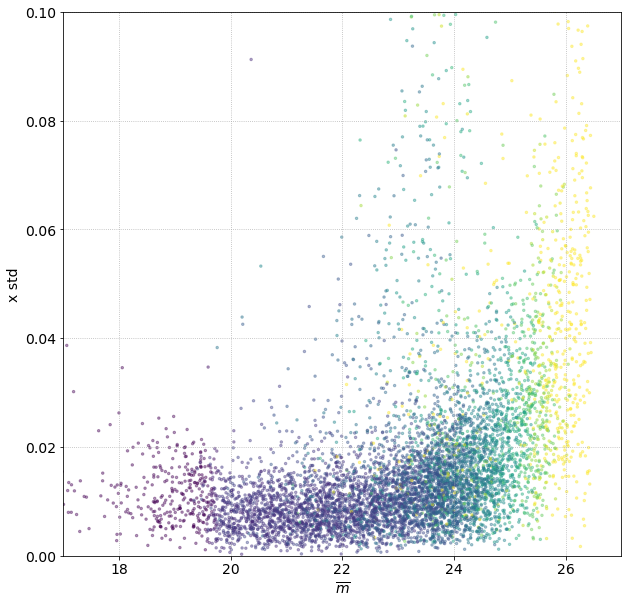

In [34]:
# stat, bedges, bn = binned_statistic(tbl['mbar'], tbl['xstd'],statistic=np.nanmedian, bins=20)
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['mbar'], tbl_i['xstd'], s=6, alpha=.4, c=tbl_i['qbar'], vmin=0, vmax=.2, cmap='viridis')

plt.xlabel('$\overline{m}$')
plt.ylabel('x std')
plt.grid(ls=':')
plt.ylim(-.0,.1)
plt.xlim(17, 27)

### Tables can be matched as well:

In [48]:
gaia_tbl = Table.read('gaia.cat', format='ascii.commented_header')
gaia_tbl['ra'].name = 'rbar'
gaia_tbl['dec'].name = 'dbar'
matched_i, matched_gaia = match_final_catalogs(tbl_i, gaia_tbl, max_distance=.04)

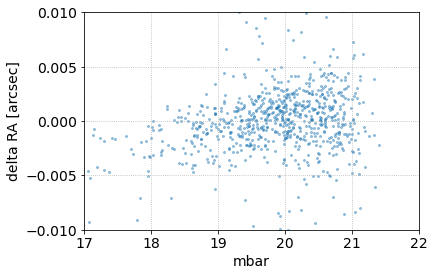

In [52]:
plt.scatter(matched_i['mbar'], (matched_i['rbar'] - matched_gaia['rbar'])*3600., s=4, alpha=.4)
plt.xlim(17., 22.)
plt.ylim(-.01, .01)
plt.ylabel('delta RA [arcsec]')
plt.xlabel('mbar')
plt.grid(ls=':')

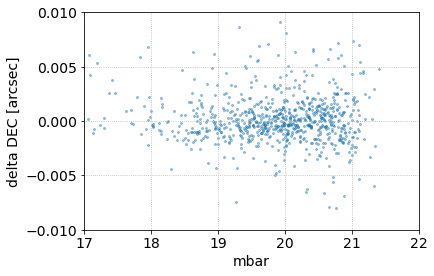

In [53]:
plt.scatter(matched_i['mbar'], (matched_i['dbar'] - matched_gaia['dbar'])*3600., s=4, alpha=.4)
plt.xlim(17., 22.)
plt.ylim(-.01, .01)
plt.ylabel('delta DEC [arcsec]')
plt.xlabel('mbar')
plt.grid(ls=':')

### Match tables from two filters

Run the same steps, with the F606W images to get an averaged catalog of those files.  Then we can match the F814W and F606W tables and make a simple CMD

In [ ]:
v_images =  [im for im in files if fits.getval(im, 'FILTER')=='F606W']
v_images =  [im for im in v_images if fits.getval(im, 'EXPTIME')>200]
run_hst1pass(v_images, hmin=hmin, fmin=fmin, pmax=pmax)
align_images(v_images, searchrad=1., gaia=True)
tbl_v = make_final_table(v_images, min_detections=3)

In [54]:
tbl_v = Table.read('F606W_final_cat.txt', format='ascii.commented_header')

In [55]:
matched_i, matched_v = match_final_catalogs(tbl_i, tbl_v)

(28.0, 17.0)

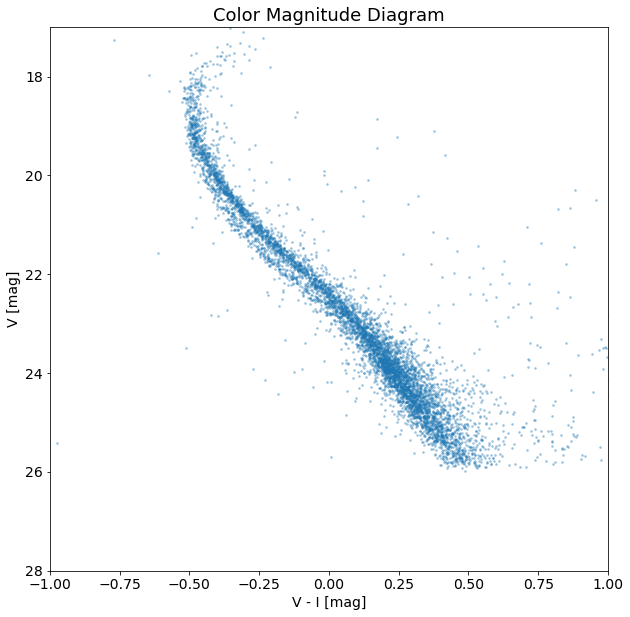

In [56]:
fig = plt.figure(figsize=(10,10))
plt.scatter(matched_v['mbar'] - matched_i['mbar'], matched_v['mbar'], s=3, alpha=.3)
plt.ylim(plt.ylim()[::-1])
plt.xlabel('V - I [mag]')
plt.ylabel('V [mag]')
plt.title('Color Magnitude Diagram')
plt.xlim(-1,1)
plt.ylim(28, 17)

# 4. Using models for other analysis
In addition to fitting stars in clusters, there are also tools for using the PSF models for addition/subtraction of stars

In [103]:
from psf_tools.PyFitting import subtract_psfs, make_models, get_subtrahend
from matplotlib.colors import LogNorm

In [66]:
data = fits.getdata('ictj45ajq_flc.fits')
mod1, mod2 = make_models('../psf_tools/PSFSTD_WFC3UV_F814W.fits')
cat = Table.read('ictj45ajq_flc_sci1_xyrd.cat', format='ascii.commented_header')
subbed = subtract_psfs(data, cat, mod1)

(0, 500)

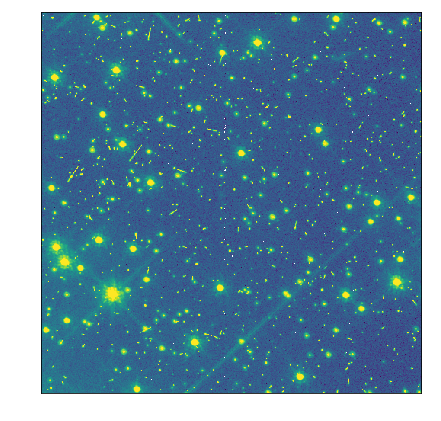

In [89]:
plt.figure(figsize=(15,7))
plt.imshow(data, vmin=12, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)

(0, 500)

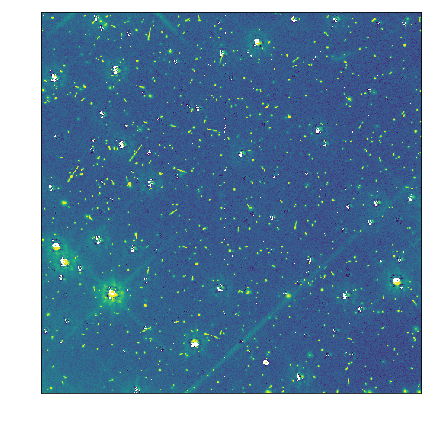

In [90]:
plt.figure(figsize=(15,7))
plt.imshow(subbed, vmin=12, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)

(0, 500)

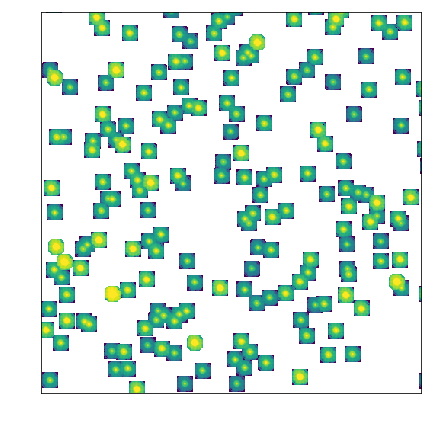

In [114]:
fluxes = np.power(10, cat['m']/-2.5).data
# subtrahend = get_subtrahend(cat['x'], cat['y'], fluxes, mod1, data.shape)
plt.figure(figsize=(15,7))
plt.imshow(np.abs(subtrahend), vmin=.001, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)